<a href="https://colab.research.google.com/github/farrelakhdan/Tugas_Text_Analitik/blob/main/Tugas_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

nltk.download('punkt')
nltk.download('stopwords')

# Load dataset (kita ambil 4 kategori saja untuk penyederhanaan)
categories = ['rec.sport.baseball', 'sci.space', 'talk.politics.mideast', 'comp.graphics']
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})

print(f"Jumlah dokumen: {len(df)}")
print(f"Distribusi kategori asli:\n{df['target'].value_counts()}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Jumlah dokumen: 3894
Distribusi kategori asli:
target
1    994
2    987
0    973
3    940
Name: count, dtype: int64


In [3]:
nltk.download('punkt_tab')
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

# Contoh preprocessing
sample_text = "This is an example sentence! It shows how preprocessing works."
print(f"Before: {sample_text}")
print(f"After: {preprocess_text(sample_text)}")

# Preprocess seluruh dataset
df['processed_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Before: This is an example sentence! It shows how preprocessing works.
After: example sentence shows preprocessing works


In [4]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(df['processed_text'])

print(f"Dimensi matriks TF-IDF: {X.shape}")

Dimensi matriks TF-IDF: (3894, 5000)


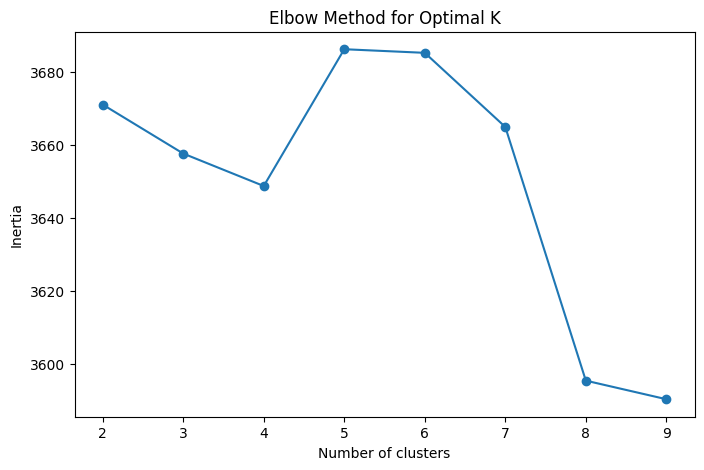

Silhouette Score: 0.005
Davies-Bouldin Index: 11.818


In [5]:
# Menentukan jumlah klaster optimal dengan Elbow Method
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Berdasarkan plot elbow, kita pilih k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
df['kmeans_cluster'] = kmeans.labels_

# Evaluasi
silhouette = silhouette_score(X, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X.toarray(), kmeans.labels_)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

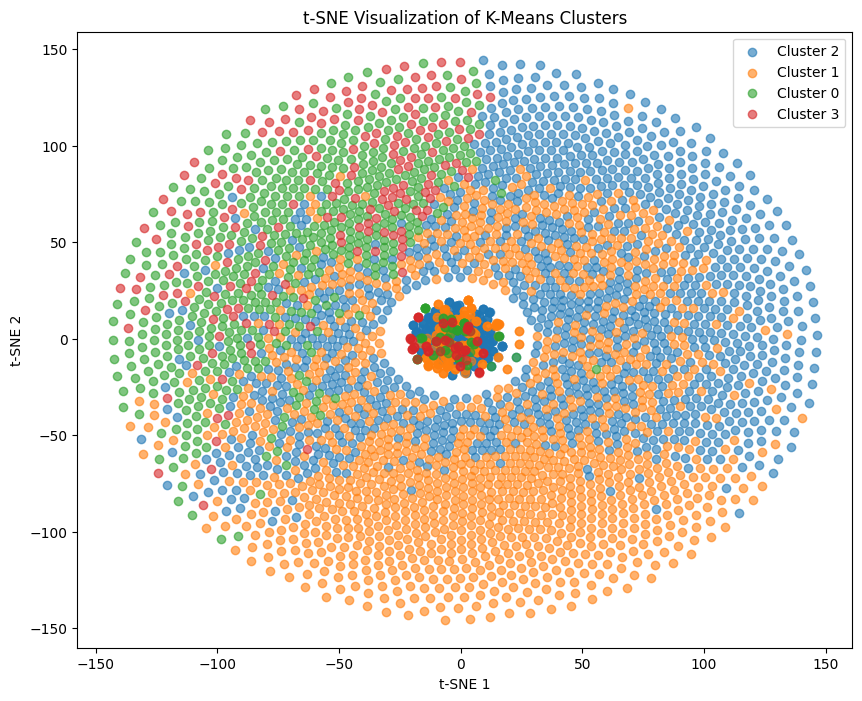

In [6]:
# Reduksi dimensi dengan t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
for cluster in df['kmeans_cluster'].unique():
    cluster_data = X_tsne[df['kmeans_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

In [7]:
# Mendapatkan top terms per cluster
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

for cluster in range(4):
    cluster_features = kmeans.cluster_centers_[cluster]
    top_indices = cluster_features.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster} top terms: {', '.join(top_words)}")

# Bandingkan dengan label asli
print("\nCross-tabulation with original categories:")
print(pd.crosstab(df['target'], df['kmeans_cluster']))

Cluster 0 top terms: thanks, please, anyone, graphics, email, would, know, looking, advance, help
Cluster 1 top terms: would, think, space, dont, one, year, like, game, get, team
Cluster 2 top terms: israel, people, jews, one, jewish, armenian, israeli, armenians, would, arab
Cluster 3 top terms: files, file, format, image, gif, images, tiff, program, convert, directory

Cross-tabulation with original categories:
kmeans_cluster    0    1    2    3
target                            
0               435   97  219  222
1                57  674  260    3
2                72  619  279   17
3                 9   54  877    0
